In [1]:
import argparse
import copy
import gc
import math
import os
import random
import time
import h5py

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
parser = argparse.ArgumentParser()

experimentName = 'DCW-GAN'

parser.add_argument("--DATASETPATH", type=str, default=os.path.expanduser('~/workspace/data/mimic-iii-processed/BINARY.h5'), help="Dataset file")

parser.add_argument("--n_epochs", type=int, default=100, help="number of epochs of training")
parser.add_argument("--n_epochs_ae", type=int, default=100, help="number of epochs of pretraining the autoencoder")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.001, help="adam: learning rate")
parser.add_argument("--weight_decay", type=float, default=0.0001, help="l2 regularization")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=32, help="number of cpu threads to use during batch generation")
parser.add_argument('--n_critic', type=int, default=5, help='number of D iters per each G iter')
parser.add_argument('--clamp', type=float, default=0.01)

parser.add_argument("--cuda", type=bool, default=True, help="CUDA activation")
parser.add_argument("--multiplegpu", type=bool, default=True, help="number of cpu threads to use during batch generation")
parser.add_argument("--num_gpu", type=int, default=1, help="Number of GPUs in case of multiple GPU")

parser.add_argument("--latent_dim", type=int, default=128, help="dimensionality of the latent space")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between samples")
parser.add_argument("--epoch_time_show", type=bool, default=True, help="interval betwen image samples")
parser.add_argument("--epoch_save_model_freq", type=int, default=100, help="number of epops per model save")
parser.add_argument("--minibatch_averaging", type=bool, default=False, help="Minibatch averaging")

parser.add_argument("--expPATH", type=str, default=os.path.expanduser('~/workspace/experiments/pytorch/model/{}'.format(experimentName)), help="Training status")

opt = parser.parse_args([])
print(opt)

Namespace(DATASETPATH='/home/mohi/workspace/data/mimic-iii-processed/BINARY.h5', b1=0.9, b2=0.999, batch_size=64, clamp=0.01, cuda=True, epoch_save_model_freq=100, epoch_time_show=True, expPATH='/home/mohi/workspace/experiments/pytorch/model/DCW-GAN', latent_dim=128, lr=0.001, minibatch_averaging=False, multiplegpu=True, n_cpu=32, n_critic=5, n_epochs=100, n_epochs_ae=100, num_gpu=1, sample_interval=100, weight_decay=0.0001)


In [4]:
######################
### Initialization ###
######################

# Create experiments DIR
if not os.path.exists(opt.expPATH):
    os.system('mkdir {0}'.format(opt.expPATH))

# opt.seed = 1024 # fix seed
opt.seed = random.randint(1, 10000)

print('Random Seed: {}'.format(opt.seed))
random.seed(opt.seed)
torch.manual_seed(opt.seed)
np.random.seed(opt.seed)
cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device BUT it is not in use...")

device = torch.device("cuda:0" if opt.cuda else "cpu")
print('using \'{}\' as the tensor processor'.format(device))

Random Seed: 6232
using 'cuda:0' as the tensor processor


In [5]:
#################################
### Reading Dataset from File ###
#################################

input_data = None
with h5py.File(opt.DATASETPATH, 'r') as hf:
    input_data = hf.get('dataset')[()]

total_samples = input_data.shape[0]
feature_size = input_data.shape[1]

In [6]:
#####################
### Dataset Model ###
#####################

class EHRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.sample_size = dataset.shape[0]
        self.feature_size = dataset.shape[1]

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        return self.dataset[idx]

In [7]:
##########################
### Dataset Processing ###
##########################

train_data = input_data[:int(0.8 * total_samples)]
test_data = input_data[int(0.8 * total_samples):]
print('total samples: {}, features: {}'.format(total_samples, feature_size))
print('training data shape: {}, testing data shape: {}, dataset type: {}'.format(train_data.shape, test_data.shape, input_data.dtype))

total samples: 46520, features: 1071
training data shape: (37216, 1071), testing data shape: (9304, 1071), dataset type: float32


In [8]:
training_dataloader = DataLoader(
    EHRDataset(dataset=train_data),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu
)

testing_dataloader = DataLoader(
    EHRDataset(dataset=test_data),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu
)

In [9]:
def weightsInit(m):
    """
    Custom weight initialization.
    :param m: Input argument to extract layer type
    :return: Initialized architecture
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [10]:
########################
### AutoEncoder Loss ###
########################

class AutoEncoderLoss(nn.Module):
    def __init__(self):
        super(AutoEncoderLoss, self).__init__()

    def forward(self, input, target):
        epsilon = 1e-12
        term = target * torch.log(input + epsilon) + (1. - target) * torch.log(1. - input + epsilon)
        return torch.mean(-torch.sum(term, 1), 0)

In [11]:
#########################
### AutoEncoder Model ###
#########################

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, stride=3, padding=0),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=8, stride=3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=5, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        return self.encoder(x.view(-1, 1, feature_size))

    def decode(self, x):
        return torch.squeeze(self.decoder(x.view(-1, 64, 28)))

    def forward(self, x):
        return self.decode(self.encode(x))

In [12]:
############################
### Model Initialization ###
############################

gc.collect()
torch.cuda.empty_cache()

autoencoder = Autoencoder()

Tensor = torch.cuda.FloatTensor if opt.cuda else torch.FloatTensor

if opt.cuda:
    autoencoder.cuda()

optimizer_A = torch.optim.Adam(autoencoder.parameters(), lr=opt.lr)
autoencoder.apply(weightsInit)

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 8, kernel_size=(5,), stride=(2,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(8, 16, kernel_size=(5,), stride=(2,), padding=(1,))
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv1d(16, 32, kernel_size=(5,), stride=(3,), padding=(1,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(32, 64, kernel_size=(8,), stride=(3,))
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(3,))
    (1): ReLU()
    (2): ConvTranspose1d(32, 16, kernel_size=(5,), stride=(3,), padding=(1,))
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose1d(16, 8, kernel_size=(5,), stride=(

In [14]:
#####################################
###### AutoEncoder Training #########
#####################################

criterion = AutoEncoderLoss()

if True:
    for epoch in range(opt.n_epochs_ae):

        training_loss = 0
        autoencoder.train()
        for batch in training_dataloader:
            batch = Variable(batch.type(Tensor))
            generated = autoencoder(batch)

            loss_A = criterion(generated, batch)

            optimizer_A.zero_grad()
            loss_A.backward()
            optimizer_A.step()
            training_loss += loss_A.item()

        errors = 0
        testing_loss = 0
        autoencoder.eval()
        for batch in testing_dataloader:
            batch = Variable(batch.type(Tensor))
            generated = autoencoder(batch)

            res = generated.round()
            diff = torch.abs(res - batch).view(1, 1, -1)[0][0].cpu().detach().numpy()
            bad_diffs = diff[diff > 0.5]
            errors += len(bad_diffs)
            testing_loss += criterion(generated, batch)
        print("[Epoch {:3d}/{:3d}] [Loss: {:10.2f}] [errors: {:6d}]".format(epoch + 1, opt.n_epochs_ae, testing_loss, errors), flush=True)

        print("[Epoch {:3d}/{:3d}] [Loss: {:10.2f}]".format(epoch + 1, opt.n_epochs_ae, training_loss), flush=True)
    torch.save(autoencoder.state_dict(), opt.expPATH + '/autoencoder.model')

else:
    autoencoder.load_state_dict(torch.load(opt.expPATH + '/autoencoder.model'))
    autoencoder.eval()

[Epoch   1/100] [Loss:    6240.40] [errors: 131308]
[Epoch   1/100] [Loss 88135.73]
[Epoch   2/100] [Loss:    7997.56] [errors:  88159]
[Epoch   2/100] [Loss 10170.56]
[Epoch   3/100] [Loss:    1643.11] [errors:  69916]
[Epoch   3/100] [Loss 5096.10]
[Epoch   4/100] [Loss:    1326.59] [errors:  66208]
[Epoch   4/100] [Loss 4020.32]
[Epoch   5/100] [Loss:    1141.12] [errors:  65463]
[Epoch   5/100] [Loss 3564.76]
[Epoch   6/100] [Loss:    1065.53] [errors:  65258]
[Epoch   6/100] [Loss 3318.05]
[Epoch   7/100] [Loss:     988.93] [errors:  64550]
[Epoch   7/100] [Loss 3121.21]
[Epoch   8/100] [Loss:     919.84] [errors:  15725]
[Epoch   8/100] [Loss 2918.24]
[Epoch   9/100] [Loss:     833.59] [errors:  15231]
[Epoch   9/100] [Loss 2681.43]
[Epoch  10/100] [Loss:     731.47] [errors:  10679]
[Epoch  10/100] [Loss 2360.36]
[Epoch  11/100] [Loss:     573.78] [errors:   2121]
[Epoch  11/100] [Loss 1957.94]
[Epoch  12/100] [Loss:      42.48] [errors:    278]
[Epoch  12/100] [Loss 407.42]
[Ep

In [15]:
errors = 0
for batch in testing_dataloader:
    batch = Variable(batch.type(Tensor))
    generated = autoencoder(batch)
    res = generated.round()
    diff = torch.abs(res - batch).view(1, 1, -1)[0][0].cpu().detach().numpy()
    bad_diffs = diff[diff > 0.5]
    errors += len(bad_diffs)
print("total number of bad digits: {}".format(errors))

total number of bad digits: 12


In [16]:
#############################
### Generator Model ###
#############################

# Output should be 64 * 28
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 64 * 16),
            nn.BatchNorm1d(64 * 16, eps=0.001, momentum=0.01),
            nn.LeakyReLU(0.2),
            nn.Linear(64 * 16, 64 * 28),
            nn.BatchNorm1d(64 * 28, eps=0.001, momentum=0.01),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [19]:
###########################
### Discriminator Model ###
###########################

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ndf = 16

        self.model = nn.Sequential(
            nn.Linear(2 * feature_size, feature_size),
            # input is (nc) x 64 x 64
            nn.Conv1d(1, ndf, 8, 4, 1),
            nn.LeakyReLU(0.2, inplace=True),
        
            # state size. (ndf) x 32 x 32
            nn.Conv1d(ndf, ndf * 2, 8, 4, 1),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        
            # state size. (ndf*2) x 16 x 16
            nn.Conv1d(ndf * 2, ndf * 4, 8, 4, 1),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        
            # state size. (ndf*4) x 8 x 8
            nn.Conv1d(ndf * 4, ndf * 8, 8, 4, 1),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        
            # state size. (ndf*8) x 4 x 4
            nn.Conv1d(ndf * 8, 1, 3, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_mean = torch.mean(x, 0).repeat(x.shape[0], 1)
        x = torch.cat((x, x_mean), 1)
        return self.model(x.view(-1, 1, 2 * feature_size)).view(-1, 1)

In [20]:
############################
### Model Initialization ###
############################

gc.collect()
torch.cuda.empty_cache()

generator = Generator()
discriminator = Discriminator()

Tensor = torch.FloatTensor

one = torch.FloatTensor([1])
mone = one * -1

if opt.cuda:
    generator.cuda()
    discriminator.cuda()
    one = one.cuda()
    mone = mone.cuda()
    Tensor = torch.cuda.FloatTensor

# generator_params = [{'params': generator.parameters()}, {'params': autoencoder.decoder.parameters(), 'lr': 1e-4}]

optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr)

generator.apply(weightsInit)
discriminator.apply(weightsInit)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2142, out_features=1071, bias=True)
    (1): Conv1d(1, 16, kernel_size=(8,), stride=(4,), padding=(1,))
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv1d(64, 128, kernel_size=(8,), stride=(4,), padding=(1,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv1d(128, 1, kernel_size=(3,), stride=(1,))
    (13): Sigmoid()
  )
)

In [21]:
if True:
    batches_done = 0

    discriminator.train()
    generator.train()

    gen_iterations = 0
    for epoch in range(opt.n_epochs):
        epoch_start = time.time()

        for batch in training_dataloader:
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch = Variable(batch.type(Tensor))

            for dp in discriminator.parameters():
                dp.requires_grad = True

            if gen_iterations < 25 or gen_iterations % 500 == 0:
                n_critic = 100
            else:
                n_critic = opt.n_critic

            for _ in range(opt.n_critic):
                for dp in discriminator.parameters():
                    dp.data.clamp_(-opt.clamp, opt.clamp)

                # reset gradients of discriminator
                optimizer_D.zero_grad()

                loss_D_real = torch.mean(discriminator(batch), dim=0)
                loss_D_real.backward(one)

                # Sample noise as generator input
                z = torch.randn(batch.shape[0], opt.latent_dim, device=device)
                # Generate a batch of images
                fake_batch = torch.squeeze(autoencoder.decode(generator(z)))

                # Error
                loss_D_fake = torch.mean(discriminator(fake_batch.detach()), dim=0)
                loss_D_fake.backward(mone)

                # Optimizer stepz
                optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------

            for dp in discriminator.parameters():
                dp.requires_grad = False

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = torch.randn(batch.shape[0], opt.latent_dim, device=device)

            # Generate a batch of images
            fake_batch = torch.squeeze(autoencoder.decode(generator(z).unsqueeze(dim=2)))

            # uncomment if there is no autoencoder
            loss_G = torch.mean(discriminator(fake_batch), dim=0)
            loss_G.backward(one)
            optimizer_G.step()
            batches_done += 1

            if batches_done % 100 == 0:
                print('[Epoch {:3d}/{:3d}] [Batch {:3d}/{:3d}] [D loss: {:.5f}] [G loss: {:.5f}]'.format(epoch + 1, opt.n_epochs, batches_done % len(training_dataloader), len(training_dataloader), loss_D_real.item() + loss_D_fake.item(), loss_G.item()))

        print('[Epoch {:3d}/{:3d}] [Time: {:.2f}] [D loss: {:.5f}] [G loss: {:.5f}]'.format(epoch + 1, opt.n_epochs, time.time() - epoch_start, loss_D_real.item() + loss_D_fake.item(), loss_G.item()))

    torch.save(generator.state_dict(), opt.expPATH + '/generator.model')
    torch.save(discriminator.state_dict(), opt.expPATH + '/discriminator.model')
else:
    generator.load_state_dict(torch.load(opt.expPATH + '/generator.model'))
    discriminator.load_state_dict(torch.load(opt.expPATH + '/discriminator.model'))

[Epoch   1/100] [Batch 100/582] [D loss: 1.00000] [G loss: 0.51010]
[Epoch   1/100] [Batch 200/582] [D loss: 1.00000] [G loss: 0.51009]
[Epoch   1/100] [Batch 300/582] [D loss: 1.00000] [G loss: 0.51009]
[Epoch   1/100] [Batch 400/582] [D loss: 1.00000] [G loss: 0.51009]
[Epoch   1/100] [Batch 500/582] [D loss: 1.00000] [G loss: 0.51009]
[Epoch   1/100] [Time: 27.50] [D loss: 1.00000] [G loss: 0.51008]
[Epoch   2/100] [Batch  18/582] [D loss: 1.00000] [G loss: 0.51009]
[Epoch   2/100] [Batch 118/582] [D loss: 1.00002] [G loss: 0.51009]
[Epoch   2/100] [Batch 218/582] [D loss: 1.00001] [G loss: 0.51010]
[Epoch   2/100] [Batch 318/582] [D loss: 0.99993] [G loss: 0.51001]
[Epoch   2/100] [Batch 418/582] [D loss: 1.00000] [G loss: 0.51008]
[Epoch   2/100] [Batch 518/582] [D loss: 1.00000] [G loss: 0.51008]
[Epoch   2/100] [Time: 27.44] [D loss: 1.00000] [G loss: 0.51009]
[Epoch   3/100] [Batch  36/582] [D loss: 1.00002] [G loss: 0.51010]
[Epoch   3/100] [Batch 136/582] [D loss: 1.00000] [G

In [22]:
autoencoder.eval()
generator.eval()
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2142, out_features=1071, bias=True)
    (1): Conv1d(1, 16, kernel_size=(8,), stride=(4,), padding=(1,))
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv1d(64, 128, kernel_size=(8,), stride=(4,), padding=(1,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv1d(128, 1, kernel_size=(3,), stride=(1,))
    (13): Sigmoid()
  )
)

In [23]:
num_fake_batches = 80
fake_data = torch.zeros((0, feature_size), device='cpu')
for _ in range(num_fake_batches):
  z = torch.randn(opt.batch_size, 128, device=device)
  generated_batch = generator(z)
  fake_batch = torch.squeeze(autoencoder.decode(generator(z).unsqueeze(dim=2)))
  fake_data = torch.cat((fake_data, fake_batch.round().to('cpu')), 0)

In [24]:
np.save(os.path.join(opt.expPATH, "synthetic.npy"), fake_data.detach().cpu().numpy(), allow_pickle=False)

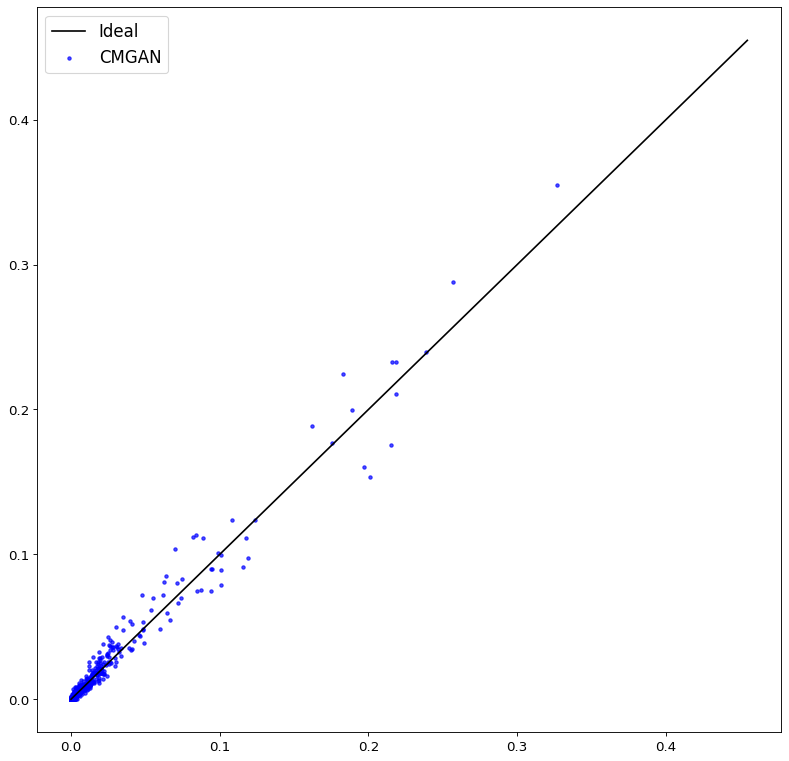

In [25]:
# gen_samples = fake_data.detach().cpu().numpy()
gen_samples = np.load(os.path.join(opt.expPATH, "synthetic.npy"), allow_pickle=False)

# Load real data
real_samples = train_data[0:gen_samples.shape[0], :]

# Dimenstion wise probability
prob_real = np.mean(real_samples, axis=0)
prob_syn = np.mean(gen_samples, axis=0)

from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.scatter(prob_real, prob_syn, c="b", alpha=0.7, label="CMGAN", s=9)
x_max = max(np.max(prob_real), np.max(prob_syn))
x = np.linspace(0, x_max + 0.1, 1000)
p2 = plt.plot(x, x, linestyle='-', color='k', label="Ideal")  # solid
plt.tick_params(labelsize=12)
plt.legend(loc=2, prop={'size': 15})
# plt.title('Scatter plot p')
# plt.xlabel('x')
# plt.ylabel('y')
plt.show()
